In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp gdrive/My\ Drive/x96_s/*.npy .
!cp -r gdrive/My\ Drive/tools/ .
!ls -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
total 4694016
drwx------ 3 root root       4096 Apr  6 22:47 gdrive
drwxr-xr-x 1 root root       4096 Apr  4 20:20 sample_data
drwx------ 2 root root       4096 Apr  6 22:48 tools
-rw------- 1 root root  801110144 Apr  6 22:47 X_test.npy
-rw------- 1 root root 2403311744 Apr  6 22:48 X_train.npy
-rw------- 1 root root  400555136 Apr  6 22:48 y_test.npy
-rw------- 1 root root 1201655936 Apr  6 22:48 y_train.npy


In [0]:
!cp gdrive/My\ Drive/12/weights9 weights

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary
import tools._my_tools as mt
import tools._torch_tools as tt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
X_train, y_train, X_test, y_test = mt.loadData("",'float16',channels_last=False)

Device is cuda:0


In [0]:
VGG_FACTOR = 0.00001
class VggLoss(nn.Module):
    def __init__(self):
        super(VggLoss, self).__init__()

        model = torchvision.models.vgg19(pretrained=True).cuda()

        self.features = nn.Sequential(
            # stop at relu4_4 (-10)
            *list(model.features.children())[:-10]
        )

        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, output, target):
        outputFeatures = self.features(output)
        targetFeatures = self.features(target)

        loss = torch.norm(outputFeatures - targetFeatures, 2)

        return config.VGG_FACTOR * loss


class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.vgg = VggLoss()
        self.l1 = nn.L1Loss()

    def forward(self, output, target) -> torch.Tensor:
        return self.vgg(output, target) + self.l1(output, target)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.activation = nn.PReLU()
        
        self.conv_setup = {
            'kernel' : (3,3),
            'stride' : (1,1),
            'padding' : 1,
            'activation' : self.activation
        }
        self.pooling_setup = {
            'kernel_size' : (2,2),
            'stride' : (2,2)
        }
        self.upsample_setup = {
            'scale_factor' : 2,
            'mode' : 'bilinear',
            'align_corners' : True
        }

        self.pooling_layer = nn.AvgPool2d(**self.pooling_setup)
        self.upsample_layer = nn.Upsample(**self.upsample_setup)
        
        self.conv32 = self._convBlock(2, 32, **self.conv_setup)
        self.conv64 = self._convBlock(32, 64, **self.conv_setup)
        self.conv128 = self._convBlock(64, 128, **self.conv_setup)
        self.conv256 = self._convBlock(128, 256, **self.conv_setup)
        self.conv256_256 = self._convBlock(256, 256, **self.conv_setup)


        self.upsample256 = self._upsampleBlock(self.upsample_layer, 256, 256, **self.conv_setup)
        self.deconv128 = self._convBlock(256, 128, **self.conv_setup)
        self.upsample128 = self._upsampleBlock(self.upsample_layer, 128, 128, **self.conv_setup)
        self.deconv64 = self._convBlock(128, 64, **self.conv_setup)
        self.upsample64 = self._upsampleBlock(self.upsample_layer, 64, 64, **self.conv_setup)
        self.deconv32 = self._convBlock(64, 32, **self.conv_setup)
        self.upsample32 = self._upsampleBlock(self.upsample_layer, 32, 32, **self.conv_setup)
        self.deconv1 = self._convBlock(32, 1, kernel=(3,3), stride=(1,1), padding=1, activation=None)
        
    def forward(self, x):
        x32 = self.conv32(x)
        x32_p = self.pooling_layer(x32)
        x64 = self.conv64(x32_p)
        x64_p = self.pooling_layer(x64)
        x128 = self.conv128(x64_p)
        x128_p = self.pooling_layer(x128)
        x256 = self.conv256(x128_p)
        x256_p = self.pooling_layer(x256)

        x = self.conv256_256(x256_p)

        # expansion

        x = self.upsample256(x)
        x += x256
        x = self.deconv128(x)

        x = self.upsample128(x)
        x += x128
        x = self.deconv64(x)

        x = self.upsample64(x)
        x += x64
        x = self.deconv32(x)
        
        x = self.upsample32(x)
        x += x32
        x = self.deconv1(x)
        
        return x
    
    @staticmethod
    def _convBlock(in_channels, out_channels, kernel, stride, padding, activation):
        net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel, stride, padding), nn.PReLU(),
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding)
        )
        if activation is not None:
            net = nn.Sequential(
                net, 
                nn.BatchNorm2d(out_channels),
                activation
            )
        return net
    @staticmethod
    def _upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
        return nn.Sequential(
            upsample,
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding), activation
        )

# model = Model().to(device)
# # model.to(device)
# if device == torch.device("cpu"):
#     print(summary(model, (2,96,96)))
# else:
#     print(summary(model.cuda(), (2,96,96)))

In [0]:
model = Model()
model.load_state_dict(torch.load("weights"))
# loss = VggLoss()
training = tt.Training(model, device, X_train, y_train, X_test, y_test)

In [0]:
try:
    training.fit(32, 5, val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")

====== HYPERPARAMETERS ======
batch_size : 32
epochs : 5
loss function : L1Loss()
optimizer : Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
device : cuda:0
===> Epoch[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[0](4074/4074): Loss: 0.0268	ETA 0:00:00	Epoch Loss: 0.0253
Epoch[0] finished in 0:26:15 with loss 0.02528592133067025
Validating on 43456 samples.
===> Validating (1358/1358):	ETA 0:00:00	Validation Loss: 0.0227Validation loss = 0.0227

----------------------------

===> Epoch[1](4074/4074): Loss: 0.0250	ETA 0:00:00	Epoch Loss: 0.0219
Epoch[1] finished in 0:26:13 with loss 0.021875541708187535
Validating on 43456 samples.
===> Validating (1358/1358):	ETA 0:00:00	Validation Loss: 0.0212Validation loss = 0.0212

----------------------------

===> Epoch[2](4074/4074): Loss: 0.0238	ETA 0:00:00	Epoch Loss: 0.0209
Epoch[2] finished in 0:26:17 with loss 0.020896317974504707
Validating on 43456 samples.
===> Validating (1358/1358):	ETA 0:00:00	Validation Loss: 0.0201Validation loss = 0.0201

----------------------------

===> Epoch[3](4074/4074): Loss: 0.0229	ETA 0:00:00	Epoch Loss: 0.0198
Epoch[3] finished in 0:26:17 with loss 0.01984988433154822
Validating on 43456 samples.
===> V

In [0]:
try:
    training.fit(32, 5, val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")

====== HYPERPARAMETERS ======
batch_size : 32
epochs : 5
loss function : L1Loss()
optimizer : Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
device : cuda:0
===> Epoch[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[0](4074/4074): Loss: 0.0213	ETA 0:00:00	Epoch Loss: 0.0188
Epoch[0] finished in 0:24:49 with loss 0.018757532070682117
Validating on 43456 samples.
===> Validating (1358/1358):	ETA 0:00:00	Validation Loss: 0.0185
Validation loss = 0.0185

----------------------------

===> Epoch[1](4074/4074): Loss: 0.0216	ETA 0:00:00	Epoch Loss: 0.0184
Epoch[1] finished in 0:24:48 with loss 0.018441196612210897
Validating on 43456 samples.
===> Validating (1358/1358):	ETA 0:00:00	Validation Loss: 0.0182
Validation loss = 0.0182

----------------------------

===> Epoch[2](4074/4074): Loss: 0.0210	ETA 0:00:00	Epoch Loss: 0.0182
Epoch[2] finished in 0:24:45 with loss 0.018199838564407024
Validating on 43456 samples.
===> Validating (1358/1358):	ETA 0:00:00	Validation Loss: 0.0181
Validation loss = 0.0181

----------------------------

===> Epoch[3](4074/4074): Loss: 0.0207	ETA 0:00:00	Epoch Loss: 0.0180
Epoch[3] finished in 0:24:43 with loss 0.017982408018928125
Validating on 43456 samples.
=

In [7]:
try:
    training.fit(32, 15, val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")

====== HYPERPARAMETERS ======
batch_size : 32
epochs : 15
loss function : L1Loss()
optimizer : Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.002
    weight_decay: 0
)
device : cuda:0
===> Epoch[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[0](4074/4074): Loss: 0.0204	ETA 0:00:00	Epoch Loss: 0.0177
Epoch[0] finished in 0:26:10 with loss 0.017671567686661074
Validating on 43456 samples.
===> Validating (1358/1358):	ETA 0:00:00	Validation Loss: 0.0175
Validation loss = 0.0175

----------------------------

===> Epoch[1](4074/4074): Loss: 0.0203	ETA 0:00:00	Epoch Loss: 0.0175
Epoch[1] finished in 0:26:10 with loss 0.01746214913532584
Validating on 43456 samples.
===> Validating (1358/1358):	ETA 0:00:00	Validation Loss: 0.0176
Validation loss = 0.0176

----------------------------

===> Epoch[2](4074/4074): Loss: 0.0201	ETA 0:00:00	Epoch Loss: 0.0173
Epoch[2] finished in 0:26:08 with loss 0.017341163048267393
Validating on 43456 samples.
===> Validating (1358/1358):	ETA 0:00:00	Validation Loss: 0.0172
Validation loss = 0.0172

----------------------------

===> Epoch[3](4074/4074): Loss: 0.0201	ETA 0:00:00	Epoch Loss: 0.0172
Epoch[3] finished in 0:26:08 with loss 0.017233165167775014
Validating on 43456 samples.
==

In [0]:
!cp weights4 gdrive/My\ Drive/12/weights14

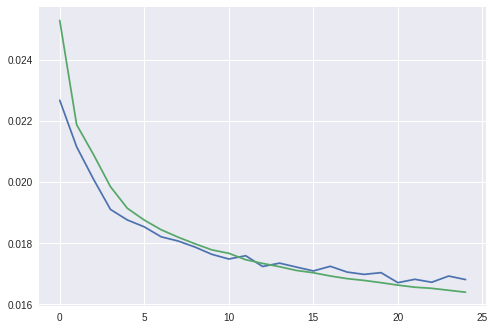

In [25]:
import matplotlib.pyplot as plt

# print(training.history)

def plotHistory(history):
    plt.plot(range(len(history['val'])),history['val'])
    plt.plot(range(len(history['train'])),history['train'])
    plt.show()
    
plotHistory(history)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


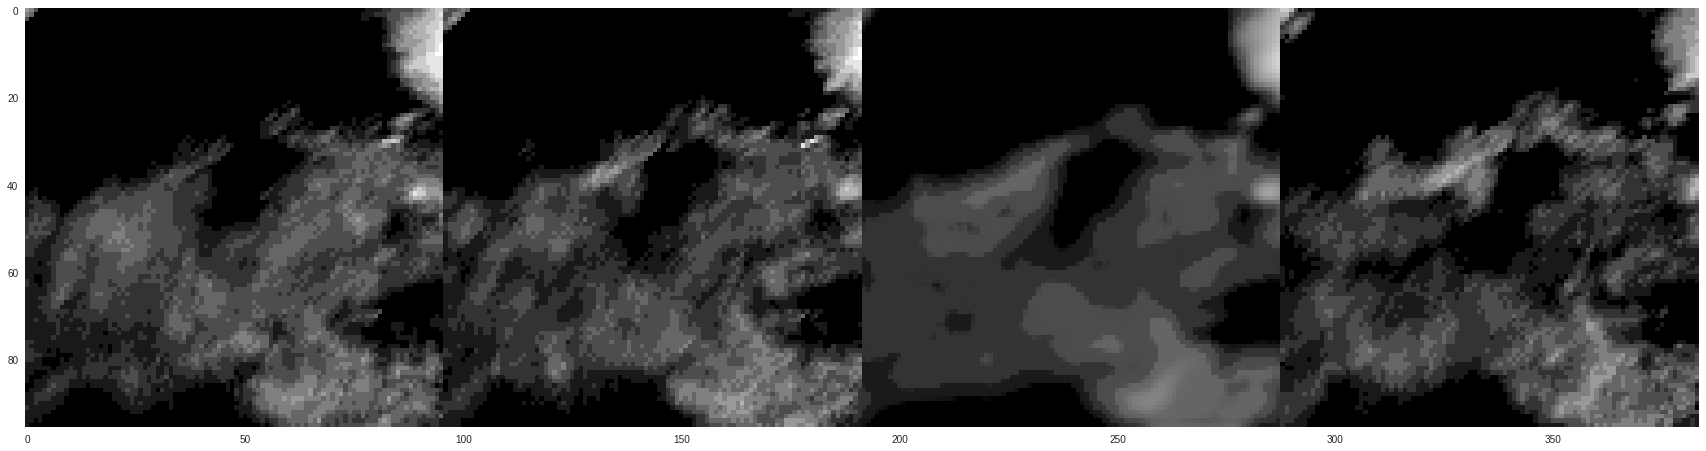

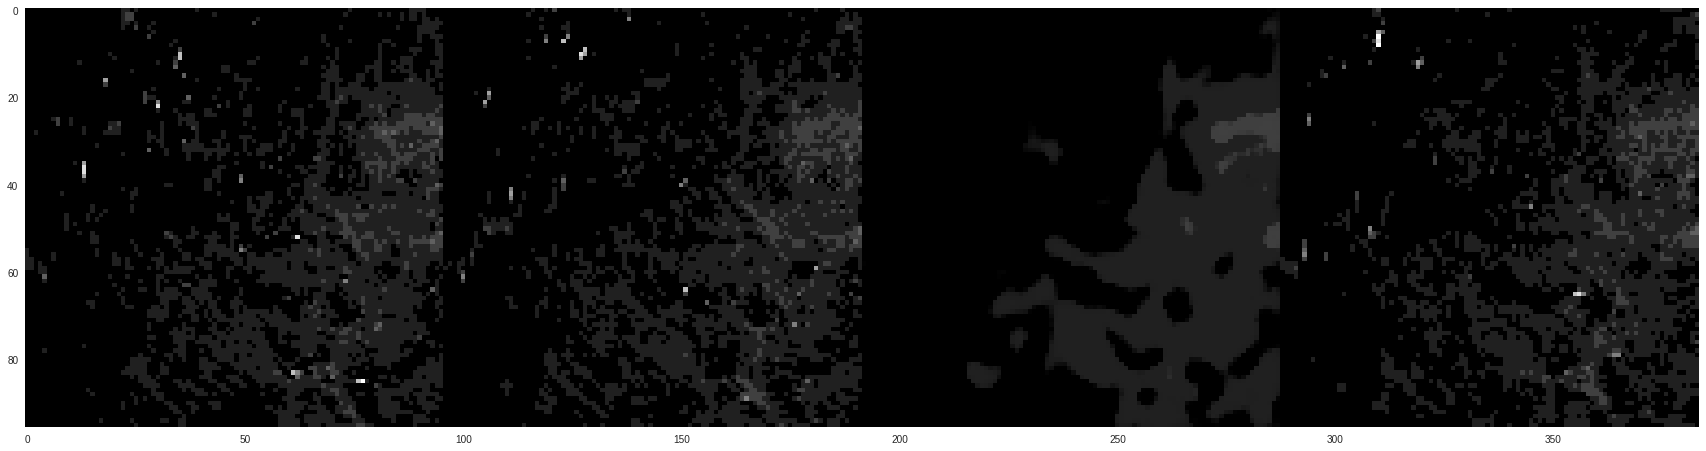

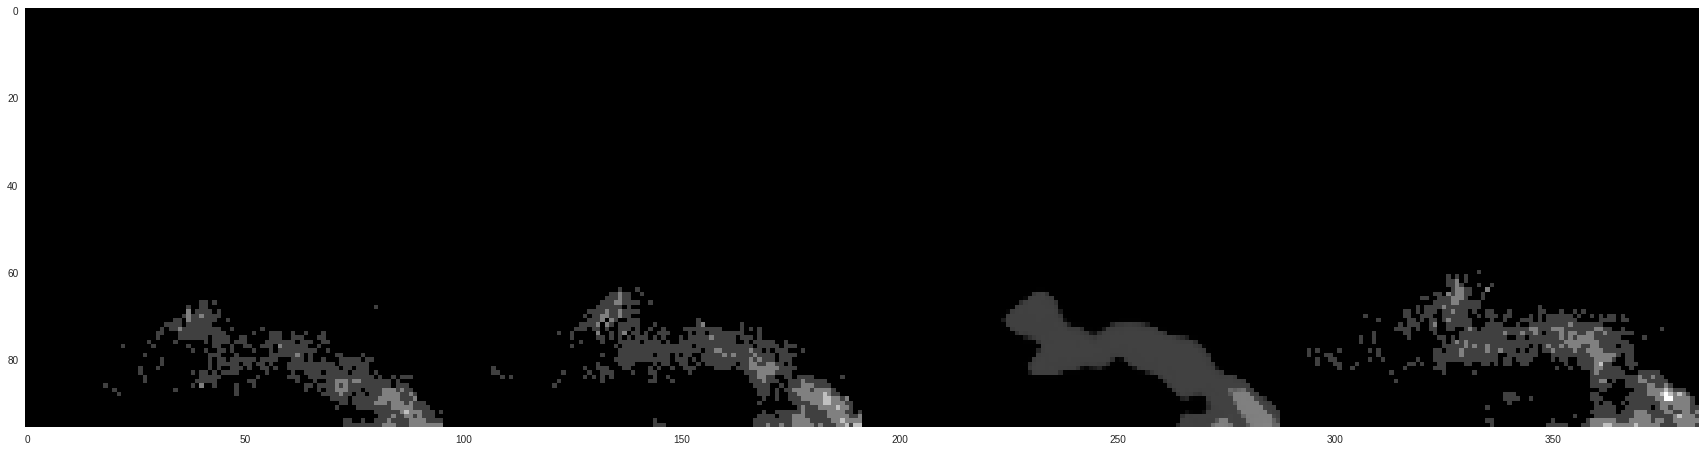

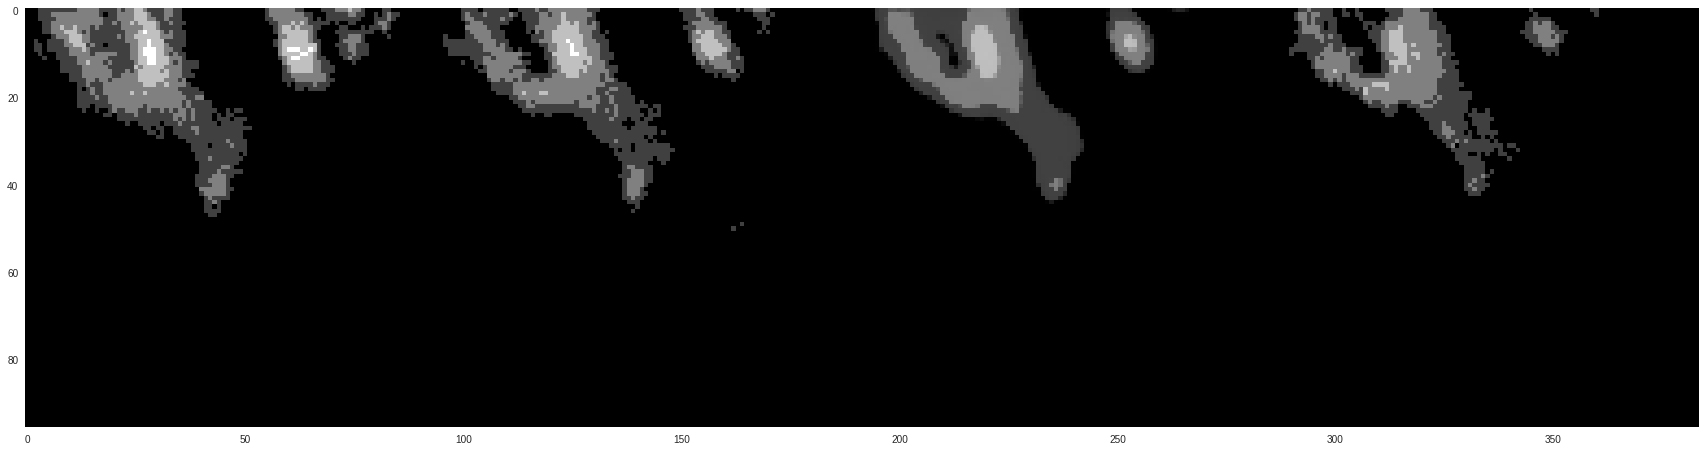

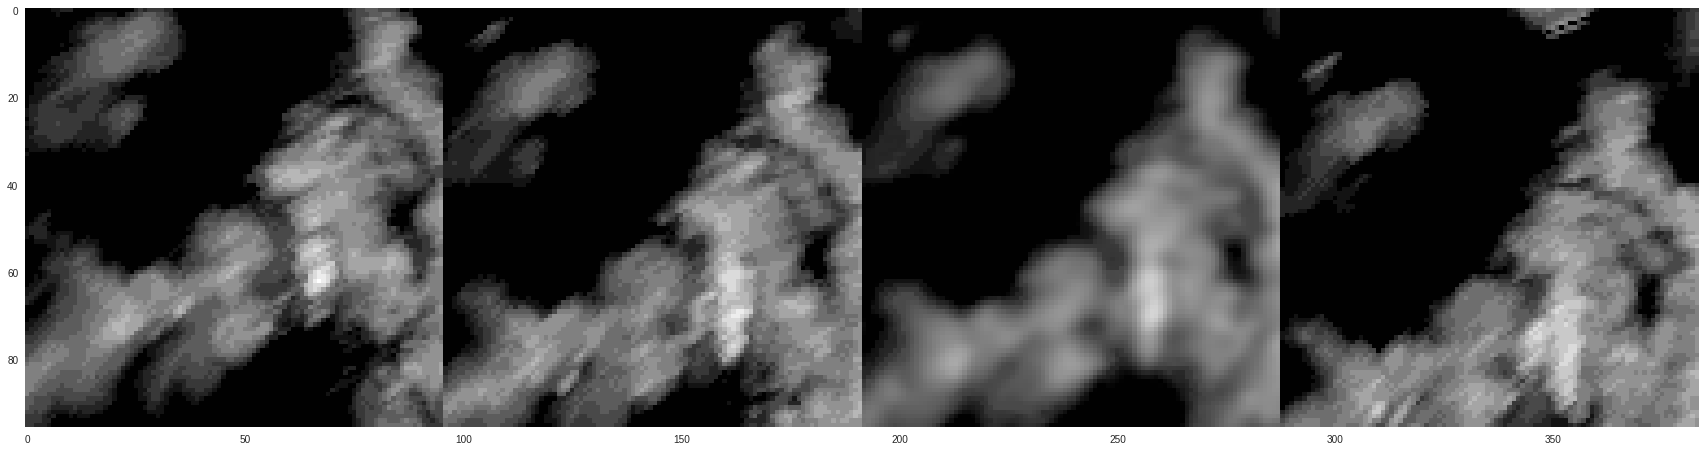

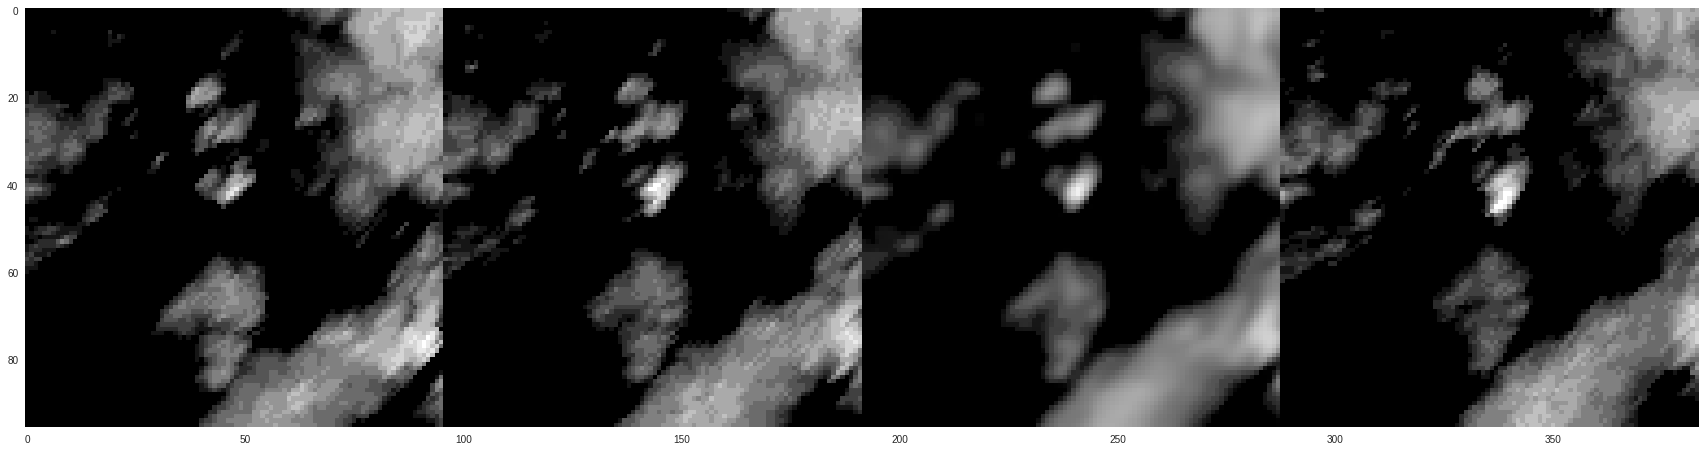

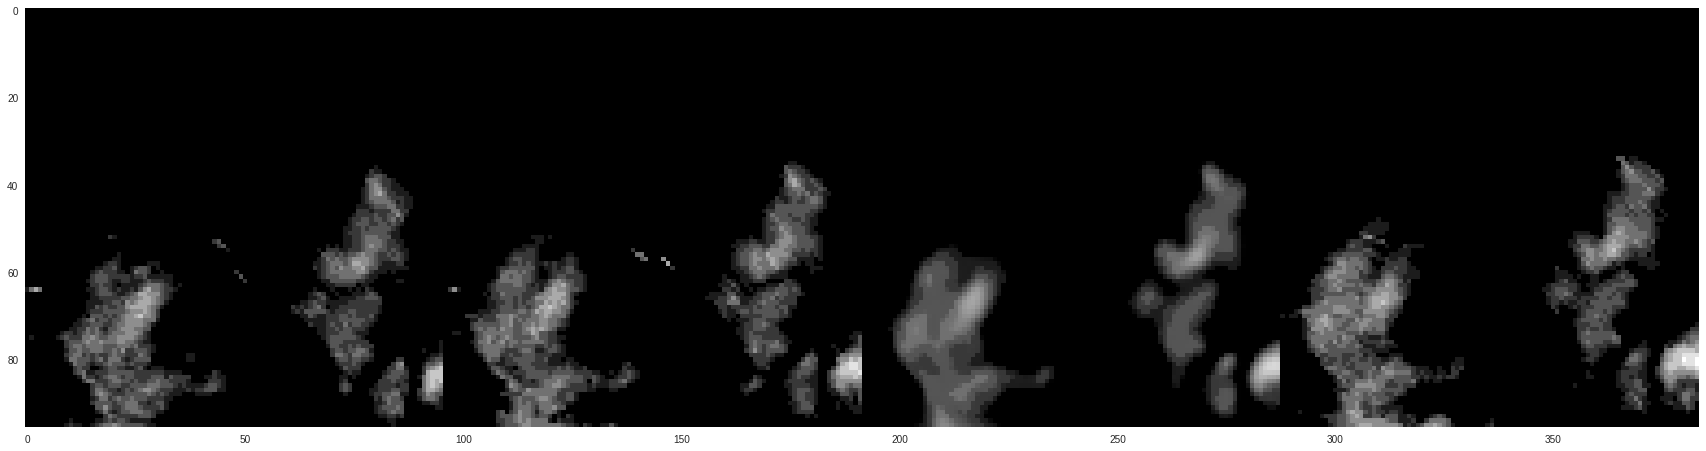

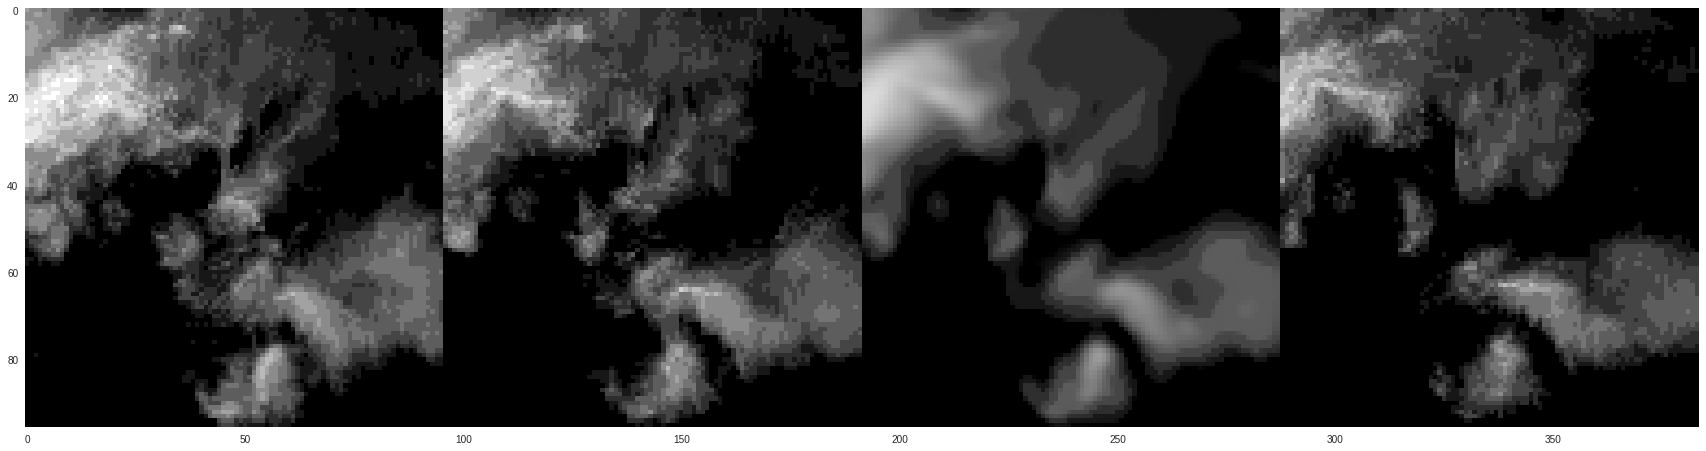

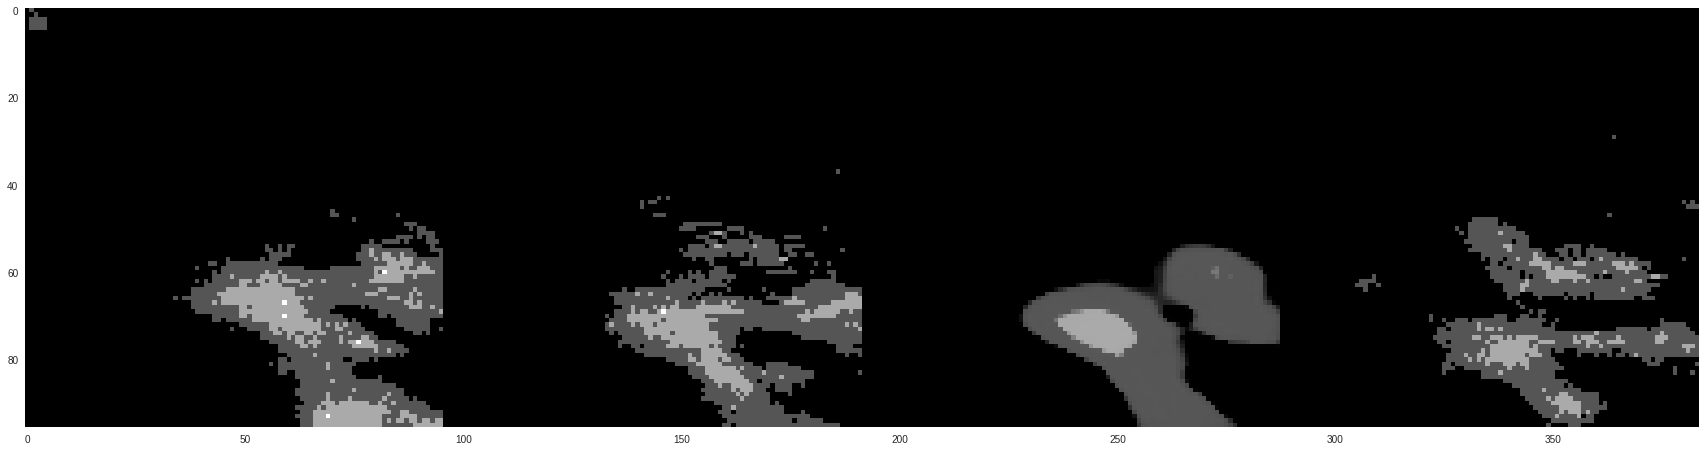

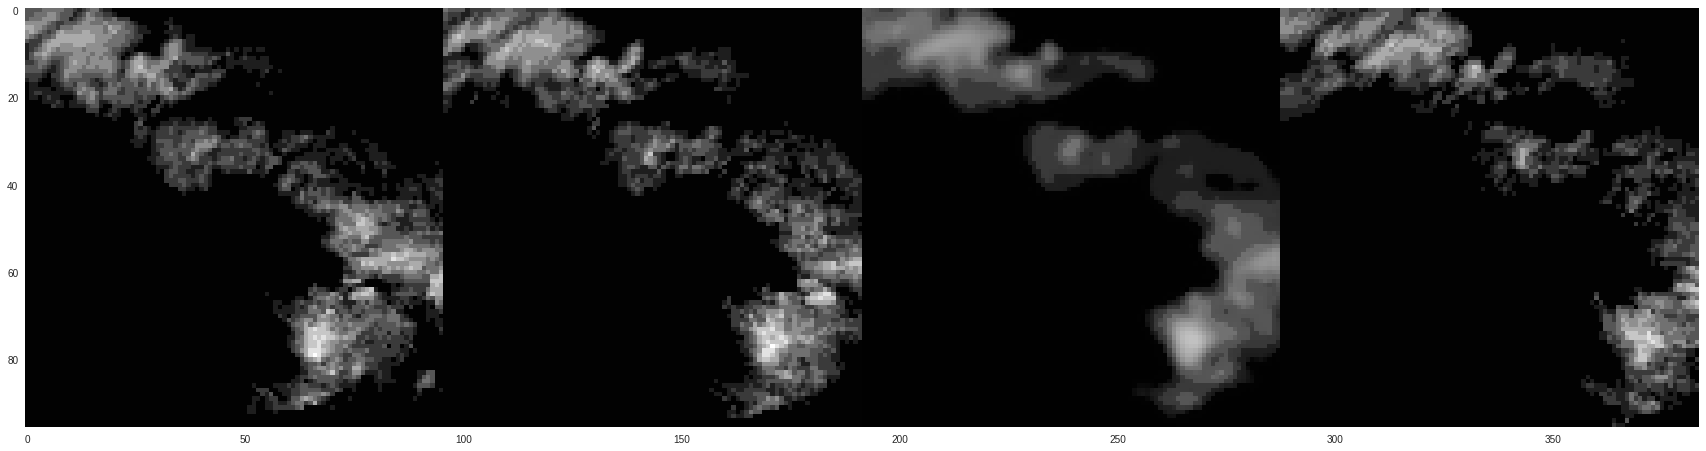

In [8]:
out = model( torch.tensor(X_test[0:10], dtype=torch.float).to(device) )
for i in range(10):
    mt.compare(i, X_test, y_test, out.cpu().detach().numpy(), folder="", channels_last=False)

In [0]:
torch.save(model.state_dict(), "weights")
# !cp weights gdrive/My\ Drive/weights3

In [0]:
model.load_state_dict(torch.load("weights10"))

In [15]:
!zip fig.zip *.png
# !zip weights.zip weights*

  adding: 00.png (deflated 1%)
  adding: 01.png (deflated 3%)
  adding: 02.png (deflated 8%)
  adding: 03.png (deflated 6%)
  adding: 04.png (deflated 1%)
  adding: 05.png (deflated 0%)
  adding: 06.png (deflated 2%)
  adding: 07.png (deflated 1%)
  adding: 08.png (deflated 3%)
  adding: 09.png (deflated 1%)


In [0]:
import csv

with open('history.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.writer(f)
    w.writerow(training.history.keys())
    w.writerows(zip(*training.history.values()))

In [23]:
from collections import defaultdict
import csv

f = 'history.csv'

history = defaultdict(list)
for record in csv.DictReader(open(f)):
    for key, val in record.items():    # or iteritems in Python 2
        history[key].append(float(val))
        
history

defaultdict(list,
            {'train': [0.02528592133067025,
              0.021875541708187535,
              0.020896317974504707,
              0.01984988433154822,
              0.019142776960392734,
              0.018757532070682117,
              0.018441196612210897,
              0.018199838564407024,
              0.017982408018928125,
              0.0177830317577509,
              0.017671567686661074,
              0.01746214913532584,
              0.017341163048267393,
              0.017233165167775014,
              0.01711101117386141,
              0.01703603210514727,
              0.016930371196003276,
              0.016843495579828702,
              0.016785002697604832,
              0.016711894267549116,
              0.016631206932350092,
              0.016563135415734426,
              0.01652704158164177,
              0.016463002981183705,
              0.016399925263305037],
             'val': [0.02267506314422359,
              0.021153340471389982,
  

In [24]:
history['train']

[0.02528592133067025,
 0.021875541708187535,
 0.020896317974504707,
 0.01984988433154822,
 0.019142776960392734,
 0.018757532070682117,
 0.018441196612210897,
 0.018199838564407024,
 0.017982408018928125,
 0.0177830317577509,
 0.017671567686661074,
 0.01746214913532584,
 0.017341163048267393,
 0.017233165167775014,
 0.01711101117386141,
 0.01703603210514727,
 0.016930371196003276,
 0.016843495579828702,
 0.016785002697604832,
 0.016711894267549116,
 0.016631206932350092,
 0.016563135415734426,
 0.01652704158164177,
 0.016463002981183705,
 0.016399925263305037]